In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
from datetime import datetime
import sys
import warnings

# Import statistical libraries
from scipy import stats
from scipy.stats import median_test, mannwhitneyu, pearsonr
from scipy.optimize import curve_fit, minimize_scalar
from scipy.integrate import quad

# Import machine learning libraries
from sklearn.preprocessing import MinMaxScaler

# Import optimization libraries
import gurobipy as gp
from gurobipy import GRB

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom utilities
sys.path.append('/Users/ludwigbaunach/Documents/Studium/PhD/Alaiko/Paper_1_Project/Main/src')
from utils.simulation_utils import simulation_main, create_weeks
from utils.parse_model_key import parse_model_key

# Configure warnings
warnings.filterwarnings('ignore')

In [2]:
# sturucture: ["model"]["variable"]["array (7,6,400)"]
single_dict = pd.read_pickle("../data/modelling_results/workforce_results_single_all_dict250223.pickle")
s_robust_dict = pd.read_pickle("../data/modelling_results/workforce_results_robust_emax_dict250223.pickle")
c_robust_dict = pd.read_pickle("../data/modelling_results/workforce_results_robust_cost_dict250223.pickle")
p_robust_dict = pd.read_pickle("../data/modelling_results/workforce_results_robust_psi_dict250223.pickle")
#p_robust_dict = pd.read_pickle("../data/modelling_results/workforce_results_robust_psi_dict231027.pickle")

In [3]:
# Parameters (must match evaluation_df)
c_e = 22         # extra worker cost per shift
p_s = 90         # productivity conversion factor for slack
penalty = 1.25 * c_e  # penalty cost per unit slack

f_model = "L_4_Time_Momentum_Lag_lgbm"
w_model = "L_6_Time_Momentum_Lag_Holiday_xgb_L_4_Time_Momentum_Lag_Weather_xgb"

# New Eval

## Workforce Eval

In [15]:
"""
Metrics Explanation:

For each simulation scenario, we aggregate daily data over the week (6 workdays) by summing.
For any variable X (e.g. cost, slack, backlog), the weekly total is computed as:
    
    X_weekly = sum_{t in week} X[t]

The weekly mean is then the average of these totals across all simulation scenarios.

Total Operational Cost Including Slack Penalty:
  We redefine the cost metric to include the penalty for service-level shortfalls (slack). Specifically,
  if:
      - cost[t] is the labor cost for day t,
      - s[t] is the slack on day t,
      - p_s is a productivity conversion factor (e.g. 90), and
      - penalty = 1.25 * c_e, with c_e being the extra worker cost (e.g. 22),
  
  then for a given scenario, the total cost including slack is:
      
      cost_total = (sum_{t in week} cost[t]) + ( (sum_{t in week} s[t]) / p_s ) * penalty
      
This reflects the cascading (ripple) effect of service-level violations.

Original Cost (Without Slack):
  The original cost is computed simply as:
      
      cost_original = sum_{t in week} cost[t]
      
Relative Metrics:
  Relative differences for any variable are computed on the weekly (total because we sum workdays) mean values. For example,
      
      rel_mean_cost_total_bench = ((Mean_cost_total_model - Mean_cost_total_bench) / Mean_cost_total_bench) * 100
      rel_mean_cost_original_bench = ((Mean_cost_original_model - Mean_cost_original_bench) / Mean_cost_original_bench) * 100
  
Statistical Testing:
  The Mann–Whitney U test is used to compare the distributions of weekly means between the model,
  the benchmark, and a perfect forecast.

Daily Metrics:
  - Daily Missed Service Level: Fraction of simulation days (across all scenarios) where slack > 0.
  - Daily Backlog: Fraction of simulation days with backlog (z > 0).
  
These daily percentages indicate the operational frequency of service-level violations and delays.
"""

#--- 2) Main evaluation
evaluation_df = pd.DataFrame()

benchmark_model = 'L_4_sarimax'
perfect_model   = 'actual'

# Define variables and their friendly names.
# (Note: 'cost' is handled separately to incorporate slack penalty.)
variables      = ['w_p', 'w_e', 'y_o', 'z', 'v', 's']
variables_name = ['planned_workers', 'extra_workers', 'overtime', 'backlog', 'overcapacity', 'service_level']

for model_key, variable_dict in single_dict.items():
    
    # Decode model key.
    decoded_name, decoded_weather, decoded_holiday = parse_model_key(model_key)
    
    # Prepare metadata for this model.
    data_dict = {
        'model':       model_key,
        'name':        decoded_name,
        'weather':     decoded_weather,
        'holiday':     decoded_holiday,
        'week':        4,      # example week index.
        'psi_scenario': 0.8,    # example service level scenario.
        'cost_scenario': 1
    }
    
    # ---- Compute Total Cost Including Slack Penalty ----
    # For each simulation scenario, compute the weekly total of original cost and slack.
    model_cost_weekly = np.sum(variable_dict['cost'], axis=1).flatten()
    model_slack_weekly = np.sum(variable_dict['s'], axis=1).flatten()
    total_cost_model = model_cost_weekly + (model_slack_weekly / p_s) * penalty
    
    bench_cost_weekly = np.sum(single_dict[benchmark_model]['cost'], axis=1).flatten()
    bench_slack_weekly = np.sum(single_dict[benchmark_model]['s'], axis=1).flatten()
    total_cost_bench = bench_cost_weekly + (bench_slack_weekly / p_s) * penalty
    
    perf_cost_weekly = np.sum(single_dict[perfect_model]['cost'], axis=1).flatten()
    perf_slack_weekly = np.sum(single_dict[perfect_model]['s'], axis=1).flatten()
    total_cost_perf = perf_cost_weekly + (perf_slack_weekly / p_s) * penalty
    
    mean_cost_total   = np.mean(total_cost_model)
    median_cost_total = np.median(total_cost_model)
    rel_mean_cost_total_bench = np.round(((mean_cost_total - np.mean(total_cost_bench)) / np.mean(total_cost_bench)) * 100, 2)
    rel_mean_cost_total_perf  = np.round(((mean_cost_total - np.mean(total_cost_perf))  / np.mean(total_cost_perf))  * 100, 2)
    
    p_value_cost_total_bench = mannwhitneyu(total_cost_model, total_cost_bench, alternative='two-sided')[1]
    p_value_cost_total_perf  = mannwhitneyu(total_cost_model, total_cost_perf, alternative='two-sided')[1]
    
    data_dict.update({
        'mean_cost_total': mean_cost_total,
        'median_cost_total': median_cost_total,
        'rel_mean_cost_total_bench': rel_mean_cost_total_bench,
        'rel_mean_cost_total_perf':  rel_mean_cost_total_perf,
        'p_value_cost_total_bench': p_value_cost_total_bench,
        'p_value_cost_total_perf':  p_value_cost_total_perf,
    })
    
    # ---- Compute Original Cost (Without Slack Penalty) ----
    # Original cost is simply the weekly sum of the 'cost' variable.
    original_cost_model = model_cost_weekly
    original_cost_bench = bench_cost_weekly
    original_cost_perf  = perf_cost_weekly
    
    mean_cost_original   = np.mean(original_cost_model)
    median_cost_original = np.median(original_cost_model)
    rel_mean_cost_original_bench = np.round(((mean_cost_original - np.mean(original_cost_bench)) / np.mean(original_cost_bench)) * 100, 2)
    rel_mean_cost_original_perf  = np.round(((mean_cost_original - np.mean(original_cost_perf))  / np.mean(original_cost_perf))  * 100, 2)
    
    p_value_cost_original_bench = mannwhitneyu(original_cost_model, original_cost_bench, alternative='two-sided')[1]
    p_value_cost_original_perf  = mannwhitneyu(original_cost_model, original_cost_perf, alternative='two-sided')[1]
    
    data_dict.update({
        'mean_cost_original': mean_cost_original,
        'median_cost_original': median_cost_original,
        'rel_mean_cost_original_bench': rel_mean_cost_original_bench,
        'rel_mean_cost_original_perf':  rel_mean_cost_original_perf,
        'p_value_cost_original_bench': p_value_cost_original_bench,
        'p_value_cost_original_perf':  p_value_cost_original_perf,
    })
    
    # ---- Compute Other Weekly Metrics for Variables (excluding cost) ----
    for var, fname in zip(variables, variables_name):
        # Sum over the week (axis=1) for each scenario.
        model_data = np.sum(variable_dict[var], axis=1).flatten()
        bench_data = np.sum(single_dict[benchmark_model][var], axis=1).flatten()
        perf_data  = np.sum(single_dict[perfect_model][var], axis=1).flatten()
        
        mean_val   = np.mean(model_data)
        median_val = np.median(model_data)
        rel_mean_bench = np.round(((mean_val - np.mean(bench_data)) / np.mean(bench_data)) * 100, 2)
        rel_mean_perf  = np.round(((mean_val - np.mean(perf_data))  / np.mean(perf_data))  * 100, 2)
        
        p_value_bench = mannwhitneyu(model_data, bench_data, alternative='two-sided')[1]
        p_value_perf  = mannwhitneyu(model_data, perf_data, alternative='two-sided')[1]
        
        data_dict.update({
            f'mean_{fname}': mean_val,
            f'median_{fname}': median_val,
            f'rel_mean_bench_{fname}': rel_mean_bench,
            f'rel_mean_perf_{fname}':  rel_mean_perf,
            f'p_value_bench_{fname}': p_value_bench,
            f'p_value_perf_{fname}':  p_value_perf
        })
    
    # ---- Compute Daily Metrics (across all simulation days) ----
    # Daily Missed Service Level: fraction of days where slack > 0.
    model_missed_frac = np.mean(variable_dict['s'].flatten() > 0)
    bench_missed_frac = np.mean(single_dict[benchmark_model]['s'].flatten() > 0)
    daily_missed_SL      = np.round(100 * model_missed_frac, 2)
    daily_missed_SL_diff = np.round(100 * (model_missed_frac - bench_missed_frac), 2)
    
    # Daily Backlog: fraction of days with backlog (z > 0).
    model_backlog_frac = np.mean(variable_dict['z'].flatten() > 0)
    bench_backlog_frac = np.mean(single_dict[benchmark_model]['z'].flatten() > 0)
    daily_backlog      = np.round(100 * model_backlog_frac, 2)
    daily_backlog_diff = np.round(100 * (model_backlog_frac - bench_backlog_frac), 2)
    
    # Daily Idle (Overcapacity): fraction of days with v > 0.
    model_idle_frac = np.mean(variable_dict['v'].flatten() > 0)
    bench_idle_frac = np.mean(single_dict[benchmark_model]['v'].flatten() > 0)
    daily_idle      = np.round(100 * model_idle_frac, 2)
    daily_idle_diff = np.round(100 * (model_idle_frac - bench_idle_frac), 2)
    
    data_dict.update({
        'daily_missed_SL': daily_missed_SL,               # in %
        'daily_missed_SL_diff': daily_missed_SL_diff,       # difference vs. benchmark (pp)
        'daily_backlog': daily_backlog,                     # in %
        'daily_backlog_diff': daily_backlog_diff,           # difference vs. benchmark (pp)
        'daily_idle': daily_idle,                           # in %
        'daily_idle_diff': daily_idle_diff                  # difference vs. benchmark (pp)
    })
    
    # Append this model's metrics.
    temp_df = pd.DataFrame([data_dict])
    evaluation_df = pd.concat([evaluation_df, temp_df], ignore_index=True)

# ---- Reorder Columns and Sort ----
# Place key cost metrics (total and original cost including slack), daily missed SL and backlog first.
desired_order = [
    'model', 'name', 'weather', 'holiday', 'week', 'psi_scenario', 'cost_scenario',
    'mean_cost_total', 'median_cost_total', 'rel_mean_cost_total_bench', 'rel_mean_cost_total_perf',
    'mean_cost_original', 'median_cost_original', 'rel_mean_cost_original_bench', 'rel_mean_cost_original_perf',
    'daily_missed_SL', 'daily_backlog'
]

# Append any remaining columns in alphabetical order.
remaining_cols = [col for col in evaluation_df.columns if col not in desired_order]
evaluation_df = evaluation_df[desired_order + sorted(remaining_cols)]

# Sort the evaluation DataFrame by the relative weekly mean total cost (including slack) vs. benchmark.
evaluation_df.sort_values("rel_mean_cost_total_bench", ascending=True, inplace=True)



# Save results to an Excel file with a date stamp in the filename.
date_string = datetime.now().strftime('%y%m%d')

# Convert roundings
exclude_cols = [
    'p_value_cost_total_perf',
    'p_value_cost_total_bench'
]

# Select columns that are not in exclude_cols and are of float type
cols_to_format = [col for col in evaluation_df.columns 
                  if col not in exclude_cols and evaluation_df[col].dtype == 'float']

evaluation_df[cols_to_format] = evaluation_df[cols_to_format].applymap(
    lambda x: format(x, '.2f') if isinstance(x, float) else x
)

# Save as excel
evaluation_df.to_excel(f"../data/modelling_results/workforce_eval_single_total_{date_string}.xlsx", index=False)

In [16]:
evaluation_df.head(10)

,model,name,weather,holiday,week,psi_scenario,cost_scenario,mean_cost_total,median_cost_total,rel_mean_cost_total_bench,...,rel_mean_bench_overcapacity,rel_mean_bench_overtime,rel_mean_bench_planned_workers,rel_mean_bench_service_level,rel_mean_perf_backlog,rel_mean_perf_extra_workers,rel_mean_perf_overcapacity,rel_mean_perf_overtime,rel_mean_perf_planned_workers,rel_mean_perf_service_level
45,actual,,No,No,4,0.80,1,20169.01,14403.09,-25.18,...,-100.00,-100.00,22.95,-100.00,nan,nan,nan,nan,0.00,nan
72,L_6_Time_Momentum_Lag_Holiday_xgb_L_4_Time_Mom...,T-C-XGB-XGB,Yes,Yes,4,0.80,1,20661.71,14642.45,-23.35,...,-91.03,46.09,3.72,-99.18,inf,inf,inf,inf,-15.64,inf
71,L_6_Time_Momentum_Lag_Holiday_xgb_L_4_Time_Mom...,T-C-XGB-LGBM,No,Yes,4,0.80,1,20729.33,14561.01,-23.10,...,-94.48,54.76,-0.44,-97.98,inf,inf,inf,inf,-19.02,inf
81,L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_L...,C-C-LGBM-XGB,Yes,No,4,0.80,1,20771.85,14563.77,-22.94,...,-90.04,31.20,3.73,-96.61,inf,inf,inf,inf,-15.63,inf
32,L_4_Time_Momentum_Lag_Weather_xgb,C-XGB,Yes,No,4,0.80,1,20773.63,14611.61,-22.93,...,-84.18,26.67,7.89,-99.64,inf,inf,inf,inf,-12.25,inf
86,L_4_Time_Momentum_Lag_Weather_xgb_L_6_Time_Mom...,C-T-XGB-XGB,Yes,Yes,4,0.80,1,20788.72,14605.71,-22.88,...,-90.63,54.73,1.63,-98.97,inf,inf,inf,inf,-17.34,inf
63,L_4_Time_Momentum_Lag_Weather_Holiday_lgbm_L_6...,C-T-LGBM-XGB,Yes,Yes,4,0.80,1,20850.36,14674.15,-22.65,...,-95.44,68.91,-3.84,-97.69,inf,inf,inf,inf,-21.78,inf
66,L_4_Time_Momentum_Lag_Weather_Holiday_lgbm_L_4...,C-C-LGBM-XGB,Yes,Yes,4,0.80,1,20865.69,14546.02,-22.59,...,-91.44,50.81,0.32,-96.25,inf,inf,inf,inf,-18.41,inf
48,L_4_sarimax_L_6_Time_Momentum_Lag_Holiday_xgb,C-T-SARIMAX-XGB,No,Yes,4,0.80,1,20972.51,15028.04,-22.20,...,-91.79,48.13,-0.34,-91.98,inf,inf,inf,inf,-18.94,inf
70,L_6_Time_Momentum_Lag_Holiday_xgb_L_4_Time_Mom...,T-C-XGB-LGBM,No,Yes,4,0.80,1,20976.40,14669.12,-22.18,...,-94.67,72.59,-4.86,-96.67,inf,inf,inf,inf,-22.61,inf


## Add asterisks

In [17]:
def add_asterisks(value, p_value):
    if p_value <= 0.001:
        return f"${value}^{{***}}$"  # Use double curly braces for proper escaping
    elif p_value <= 0.01:
        return f"${value}^{{**}}$"
    elif p_value <= 0.05:
        return f"${value}^{{*}}$"
    else:
        return f"{value}"



# Columns we want to show in the final table
# (All model IDs plus the selected metrics with p-value asterisks)
final_cols = [
    'model',
    'name',
    'weather',
    'holiday',
    'week',
    'psi_scenario',
    'cost_scenario',
    'rel_mean_cost_total_perf',
    'rel_mean_cost_total_bench',
    'daily_missed_SL',
    'daily_missed_SL_diff',
    'daily_idle',
    'daily_idle_diff'
]


# Build a new DataFrame for the custom table
custom_table_df = pd.DataFrame(columns=final_cols)

for idx, row in evaluation_df.iterrows():
    # For daily metrics, you likely don't have p-values. We'll use p_value=1 to avoid adding asterisks.
    # If you do have p-values for them, replace '1' with the appropriate column reference.
    row_dict = {
        'model':               row['model'],
        'name':                row['name'],
        'weather':             row['weather'],
        'holiday':             row['holiday'],
        'week':                row['week'],
        'psi_scenario':        row['psi_scenario'],
        'cost_scenario':       row['cost_scenario'],

        # Add asterisks for cost vs. perfect forecast
        'rel_mean_cost_total_perf': add_asterisks(
            row['rel_mean_cost_total_perf'],
            row['p_value_cost_total_perf']
        ),

        # Add asterisks for cost vs. benchmark
        'rel_mean_cost_total_bench': add_asterisks(
            row['rel_mean_cost_total_bench'],
            row['p_value_cost_total_bench']
        ),

        # Daily metrics typically lack p-values, so we set p=1 => no asterisks
        'daily_missed_SL':      add_asterisks(row['daily_missed_SL'], 1),
        'daily_missed_SL_diff': add_asterisks(row['daily_missed_SL_diff'], 1),
        'daily_idle':           add_asterisks(row['daily_idle'], 1),
        'daily_idle_diff':      add_asterisks(row['daily_idle_diff'], 1)
    }

    custom_table_df = pd.concat([custom_table_df, pd.DataFrame([row_dict])], ignore_index=True)

# Finally, save your custom table to Excel (or just print it)
custom_table_df.to_excel("../data/modelling_results/workforce_eval_single_total_with_asterisks.xlsx", index=False)


## Slack Penalty Sensitivity Analysis

In [7]:
"""
Sensitivity Analysis Method:

For each simulation model (from the single_dict) we calculate the total operational cost that includes
both the original labor cost and the cost penalty due to slack. For a given simulation scenario,
the total cost including slack is computed as:

    cost_total = (sum_{t in week} cost[t]) + ( (sum_{t in week} s[t]) / p_s ) * (penalty_factor * c_e)

where:
    - cost[t] is the daily labor cost,
    - s[t] is the slack (service-level shortfall) on day t,
    - p_s is a productivity conversion factor (e.g., 90),
    - c_e is the extra worker cost (e.g., 22), and
    - penalty_factor is varied between 1.0 and 1.5 (in steps of 0.1).

The rationale for using 1.0 as the minimum is that it represents the base cost of extra workers. Any
penalty factor above 1.0 reflects additional costs (e.g., lost customer goodwill, expedited shipping, etc.)
that exceed the direct extra worker cost.

For each penalty_factor, we compute the weekly mean total cost for:
  - the model under consideration,
  - the benchmark (e.g., 'L_4_sarimax'), and
  - the perfect forecast (e.g., 'actual').

Then we calculate the relative cost savings (in percentage) compared to the benchmark and perfect forecast as:

    rel_cost_savings = ((mean_cost_model - mean_cost_reference) / mean_cost_reference) * 100

This sensitivity analysis shows how the penalty cost influences the relative cost performance.
"""

# Parameters for slack penalty cost calculation
c_e = 22         # extra worker cost per shift
p_s = 90         # productivity conversion factor for slack

# Define the penalty factors to test: 
penalty_factors = [0.5, 0.75, 1, 1.25, 1.5]

benchmark_model = 'L_4_sarimax'
perfect_model   = 'actual'
sensitivity_results = []

# Loop over each model in single_dict
for model_key, variable_dict in single_dict.items():
    # Use parse_model_key to get model identification fields
    decoded_name, weather_flag, holiday_flag = parse_model_key(model_key)
    
    # Loop over each penalty factor
    for factor in penalty_factors:
        # For current model: compute weekly totals for cost and slack
        model_cost_weekly = np.sum(variable_dict['cost'], axis=1).flatten()
        model_slack_weekly = np.sum(variable_dict['s'], axis=1).flatten()
        total_cost_model = model_cost_weekly + (model_slack_weekly / p_s) * (factor * c_e)
        mean_cost_model = np.mean(total_cost_model)
        
        # For benchmark model
        bench_cost_weekly = np.sum(single_dict[benchmark_model]['cost'], axis=1).flatten()
        bench_slack_weekly = np.sum(single_dict[benchmark_model]['s'], axis=1).flatten()
        total_cost_bench = bench_cost_weekly + (bench_slack_weekly / p_s) * (factor * c_e)
        mean_cost_bench = np.mean(total_cost_bench)
        
        # For perfect forecast model
        perf_cost_weekly = np.sum(single_dict[perfect_model]['cost'], axis=1).flatten()
        perf_slack_weekly = np.sum(single_dict[perfect_model]['s'], axis=1).flatten()
        total_cost_perf = perf_cost_weekly + (perf_slack_weekly / p_s) * (factor * c_e)
        mean_cost_perf = np.mean(total_cost_perf)
        
        # Compute relative cost savings (%) compared to benchmark and perfect forecast
        rel_cost_savings_bench = np.round(((mean_cost_model - mean_cost_bench) / mean_cost_bench) * 100, 2)
        rel_cost_savings_perf = np.round(((mean_cost_model - mean_cost_perf) / mean_cost_perf) * 100, 2)
        
        sensitivity_results.append({
            'model': model_key,
            'name': decoded_name,
            'weather': weather_flag,
            'holiday': holiday_flag,
            'penalty_factor': factor,
            'rel_cost_savings_bench': rel_cost_savings_bench,
            'rel_cost_savings_perf': rel_cost_savings_perf
        })

# Convert the results to a DataFrame for display and further analysis.
sensitivity_df = pd.DataFrame(sensitivity_results)
sensitivity_df.to_excel(f"../data/modelling_results/workforce_penalty_sensitivity_{date_string}.xlsx", index=False)
sensitivity_df


,model,name,weather,holiday,penalty_factor,rel_cost_savings_bench,rel_cost_savings_perf
0,L_3_sarima,W-SARIMA,No,No,0.50,8.23,20.86
1,L_3_sarima,W-SARIMA,No,No,0.75,9.69,30.53
2,L_3_sarima,W-SARIMA,No,No,1.00,10.98,40.19
3,L_3_sarima,W-SARIMA,No,No,1.25,12.12,49.85
4,L_3_sarima,W-SARIMA,No,No,1.50,13.15,59.51
...,...,...,...,...,...,...,...
450,L_6_Time_Momentum_Lag_Weather_Holiday_xgb_L_4_...,T-C-XGB-XGB,Yes,Yes,0.50,-6.25,4.69
451,L_6_Time_Momentum_Lag_Weather_Holiday_xgb_L_4_...,T-C-XGB-XGB,Yes,Yes,0.75,-10.62,6.36
452,L_6_Time_Momentum_Lag_Weather_Holiday_xgb_L_4_...,T-C-XGB-XGB,Yes,Yes,1.00,-14.49,8.02
453,L_6_Time_Momentum_Lag_Weather_Holiday_xgb_L_4_...,T-C-XGB-XGB,Yes,Yes,1.25,-17.93,9.69


## Robustness

In [8]:
def calc_weekly_robust_savings(robust_dict, c_e, p_s, penalty):

    # Variables to analyze and their friendly names
    variables = ['cost', 'w_p', 'w_e', 'y_o', 'z', 'v', "s"]
    variables_name = ['cost', 'planned_workers', 'extra_workers', 'overtime', 'backlog', 'overcapacity', "slack"]

    # Benchmark and perfect forecast keys (as in evaluation_df)
    benchmark_model = 'L_4_sarimax'
    perfect_model = 'actual'

    # Initialize DataFrame to store weekly evaluation metrics
    weekly_evaluation_df = pd.DataFrame()

    # Loop over scenarios
    for scenario in robust_dict.keys():
        # Loop over models in this scenario
        for model, var_dict in robust_dict[scenario].items():
            num_weeks = robust_dict[scenario][model]['cost'].shape[0]
            
            # Empty np array xontainers to accumulate weekly mean cost (including slack penalty) for total calculations
            weekly_totals_model = np.empty(0)
            weekly_totals_bench = np.empty(0)
            weekly_totals_perf = np.empty(0)

            # Process each week
            for week in range(num_weeks):
                data_dict = {
                    'model': model,
                    'week': week + 1,
                    'scenario': scenario,
                }

                for variable, fname in zip(variables, variables_name):
                    if variable == 'cost':
                        # For cost: sum over workdays (axis=0 (axis 1 if week is not given!)) per simulation scenario and add slack penalty
                        # robust_dict[scenario][model]['cost'][week, :, :] shape: (num_simulations, num_days)
                        weekly_model_array = np.sum(var_dict['cost'][week, :, :], axis=0) + \
                            (np.sum(var_dict['s'][week, :, :], axis=0) / p_s) * penalty
                        
                        weekly_bench_array = np.sum(robust_dict[scenario][benchmark_model]['cost'][week, :, :], axis=0) + \
                            (np.sum(robust_dict[scenario][benchmark_model]['s'][week, :, :], axis=0) / p_s) * penalty
                        
                        #print(weekly_model_array.shape, weekly_bench_array.shape)
                        
                        weekly_perf_array = np.sum(robust_dict[scenario][perfect_model]['cost'][week, :, :], axis=0) + \
                            (np.sum(robust_dict[scenario][perfect_model]['s'][week, :, :], axis=0) / p_s) * penalty

                        # Compute weekly mean for cost (including slack) for this week
                        week_model_mean = np.mean(weekly_model_array)
                        week_bench_mean = np.mean(weekly_bench_array)
                        week_perf_mean = np.mean(weekly_perf_array)
                        
                        # Save these weekly means for overall (total) cost calculations
                        weekly_totals_model = np.concatenate((weekly_totals_model, weekly_model_array))
                        weekly_totals_bench = np.concatenate((weekly_totals_bench, weekly_bench_array))
                        weekly_totals_perf = np.concatenate((weekly_totals_perf, weekly_perf_array))
                        

                    else:
                        # For non-cost variables, simply sum over days per simulation scenario and take the mean
                        weekly_model_array = np.sum(var_dict[variable][week, :, :], axis=0)
                        weekly_bench_array = np.sum(robust_dict[scenario][benchmark_model][variable][week, :, :], axis=0)
                        weekly_perf_array = np.sum(robust_dict[scenario][perfect_model][variable][week, :, :], axis=0)
                        week_model_mean = np.mean(weekly_model_array)
                        week_bench_mean = np.mean(weekly_bench_array)
                        week_perf_mean = np.mean(weekly_perf_array)
                    
                    # Compute weekly relative difference (%) for this variable
                    rel_bench_value = np.round(((week_model_mean - week_bench_mean) / week_bench_mean) * 100, 2)
                    rel_perf_value = np.round(((week_model_mean - week_perf_mean) / week_perf_mean) * 100, 2)

                    # Also compute the average relative difference across scenarios for this week
                    rel_bench_avg = np.round(np.mean(((weekly_model_array - weekly_bench_array) / weekly_bench_array) * 100), 2)
                    rel_perf_avg = np.round(np.mean(((weekly_model_array - weekly_perf_array) / weekly_perf_array) * 100), 2)
                    # Standard Deviation
                    rel_bench_std = np.round(np.std(((weekly_model_array - weekly_bench_array) / weekly_bench_array) * 100), 2)

                    # Compute p-values using Mann–Whitney U test for the weekly arrays
                    _, p_value_bench = mannwhitneyu(weekly_model_array, weekly_bench_array, alternative='two-sided')
                    _, p_value_perf = mannwhitneyu(weekly_model_array, weekly_perf_array, alternative='two-sided')

                    data_dict.update({
                        f'sum_{fname}': week_model_mean,
                        f'median_{fname}': np.round(np.median(weekly_model_array), 2),
                        f'rel_bench_{fname}': rel_bench_value,
                        f'rel_bench_avg_{fname}': add_asterisks(rel_bench_avg, p_value_bench),
                        f'rel_bench_std_{fname}': f'({rel_bench_std})',
                        f'p_bench_{fname}': p_value_bench,
                        f'rel_perf_avg_{fname}': add_asterisks(rel_perf_avg, p_value_perf),
                    })
                # Append the weekly data for this model & scenario
                weekly_evaluation_df = pd.concat([weekly_evaluation_df, pd.DataFrame(data_dict, index=[0])], ignore_index=True)

            # After processing all weeks for this model and scenario, compute overall total cost metrics
            total_model_mean = np.mean(weekly_totals_model)
            total_bench_mean = np.mean(weekly_totals_bench)
            total_perf_mean = np.mean(weekly_totals_perf)
            rel_t_bench = np.round(((total_model_mean - total_bench_mean) / total_bench_mean) * 100, 2)
            
            # Compute the standard deviation of the weekly relative differences for cost
            weekly_rel_diff = ((np.array(weekly_totals_model) - np.array(weekly_totals_bench)) / np.array(weekly_totals_bench)) * 100
            rel_t_std = np.round(np.std(weekly_rel_diff), 2)
            # Compute overall p-value on weekly cost arrays
            _, p_t_value_bench = mannwhitneyu(np.array(weekly_totals_model), np.array(weekly_totals_bench), alternative='two-sided')

            # Decorate the overall relative difference with asterisks
            rel_t_bench_ast = add_asterisks(rel_t_bench, p_t_value_bench)

            # Update all rows corresponding to this model & scenario with the total cost metrics
            idx = (weekly_evaluation_df['model'] == model) & (weekly_evaluation_df['scenario'] == scenario)
            weekly_evaluation_df.loc[idx, 'rel_t_bench_cost'] = rel_t_bench_ast
            weekly_evaluation_df.loc[idx, 'rel_t_bench_avg_cost'] = rel_t_bench_ast
            weekly_evaluation_df.loc[idx, 'rel_t_bench_std_cost'] = f'({rel_t_std})'
    return weekly_evaluation_df

def scenario_pivot(df, model, path_name="test_scenario_table"):
    # Filter the DataFrame to include only a specific model
    filtered_df = df[df['model'] == model]

    # Create pivot tables for rel_bench_cost and std_cost
    pivot_rel_bench = pd.pivot_table(
        filtered_df,
        values='rel_bench_avg_cost',
        index=['scenario'],
        columns=['week'],
        aggfunc="first"
    )
    
    # Add the "Average" column, which contains the first value per scenario from "rel_t_benchcost"
    average_values = filtered_df.groupby('scenario')['rel_t_bench_avg_cost'].first()
    pivot_rel_bench['Total'] = average_values
    
    pivot_std = pd.pivot_table(
        filtered_df,
        values=f'rel_bench_std_cost',
        index=['scenario'],
        columns=['week'],
        aggfunc="first"
    )
    
    # Add the "Average" column, which contains the first value per scenario from "rel_t_benchcost"
    std_values = filtered_df.groupby('scenario')['rel_t_bench_std_cost'].first()
    pivot_std['Total'] = std_values
    # Add a new level to the index to distinguish between rel_bench_cost and std_cost
    pivot_rel_bench['Metric'] = 'Cost Savings in %'
    pivot_std['Metric'] = 'Standard Deviation'
    
    pivot_rel_bench.set_index('Metric', append=True, inplace=True)
    pivot_std.set_index('Metric', append=True, inplace=True)

    # Concatenate the two DataFrames to create a multi-index DataFrame
    combined_pivot = pd.concat([pivot_rel_bench, pivot_std]).sort_index()


    combined_pivot.to_excel(f"../data/modelling_results/{path_name}.xlsx")
    
    return combined_pivot

In [10]:
# e_max
weekly_emax_evaluation_df = calc_weekly_robust_savings(s_robust_dict, c_e=c_e, p_s=p_s, penalty=penalty)
weekly_emax_evaluation_df.to_excel(f"../data/modelling_results/e_max_r_results.xlsx")
scenario_pivot(weekly_emax_evaluation_df, w_model, path_name="tab_emax_scenario_table")

# cost
weekly_cost_evaluation_df = calc_weekly_robust_savings(c_robust_dict, c_e=c_e, p_s=p_s, penalty=penalty)
weekly_cost_evaluation_df.to_excel(f"../data/modelling_results/cost_r_results.xlsx")
scenario_pivot(weekly_cost_evaluation_df, w_model, path_name="tab_cost_scenario_table")

# psi
weekly_psi_evaluation_df = calc_weekly_robust_savings(p_robust_dict, c_e=c_e, p_s=p_s, penalty=penalty)
weekly_psi_evaluation_df.to_excel(f"../data/modelling_results/psi_r_results.xlsx")
scenario_pivot(weekly_psi_evaluation_df, w_model, path_name="tab_psi_scenario_table")

week                                     1              2              3  \
scenario Metric                                                            
0        Cost Savings in %   $10.26^{***}$  $-3.34^{***}$  $-2.79^{***}$   
         Standard Deviation         (3.71)         (2.62)         (4.15)   
1        Cost Savings in %    $8.48^{***}$  $-4.26^{***}$  $-3.18^{***}$   
         Standard Deviation         (3.69)         (3.81)          (3.9)   
2        Cost Savings in %    $6.62^{***}$  $-6.22^{***}$  $-3.62^{***}$   
         Standard Deviation         (3.57)         (5.77)         (4.24)   

week                                     4               5              6  \
scenario Metric                                                             
0        Cost Savings in %    $-5.6^{***}$  $-64.18^{***}$  $-3.79^{***}$   
         Standard Deviation         (4.92)          (9.42)         (5.95)   
1        Cost Savings in %   $-6.78^{***}$  $-68.27^{***}$  $-2.69^{***}$   
         Standard Deviation         (6.04)          (7.21)         (5.75)   
2        Cost Savings in %   $-9.29^{***}$  $-71.41^{***}$    $-1.44^{*}$   
         Standard Deviation         (8.57)           (5.5)         (5.84)   

week                              7           Total  
scenario Metric                                      
0        Cost Savings in %     -0.3  $-20.72^{***}$  
         Standard Deviation  (3.06)         (23.27)  
1        Cost Savings in %    -0.13  $-23.35^{***}$  
         Standard Deviation  (2.88)         (24.33)  
2        Cost Savings in %    -0.07  $-25.89^{***}$  
         Standard Deviation  (2.73)         (25.22)

In [11]:
scenario_pivot(weekly_emax_evaluation_df, model, path_name="tab_emax_scenario_table")

NameError: name 'model' is not defined

### Further Analysis

In [76]:

# Filter out rows where 'model' is "L_4_Time_Momentum_Lag_Weather_Holiday_xgb"
filtered_df = weekly_p_evaluation_df[weekly_p_evaluation_df["model"] != "L_4_Time_Momentum_Lag_Weather_Holiday_xgb"]

# Select rows where 'week' is 4 or 5
filtered_df = filtered_df[filtered_df["week"].isin([4, 5])]

# Select only the required columns
columns_to_keep = [
    "model", "scenario", "week",
    "sum_cost", "median_cost", "rel_bench_avg_cost", "sum_planned_workers", 
    "median_planned_workers", "rel_bench_planned_workers", 
    "rel_bench_avg_planned_workers", "rel_bench_avg_extra_workers", 
    "rel_bench_std_extra_workers", "p_bench_extra_workers", 
    "sum_slack", "median_slack", "rel_bench_avg_slack", "rel_bench_avg_overcapacity"
]
filtered_df = filtered_df[columns_to_keep]

In [87]:
filtered_df[(filtered_df["week"] == 5) & (filtered_df["scenario"] == 0)][["model", "sum_planned_workers"]]

,model,sum_planned_workers
11,actual,125.747541
18,L_4_sarimax,35.675575
25,L_4_Time_Momentum_Lag_lgbm,59.760255


In [89]:
filtered_df[(filtered_df["week"] == 4) & (filtered_df["scenario"] == 2)][["model", "sum_planned_workers"]]

,model,sum_planned_workers
66,actual,97.651817
73,L_4_sarimax,64.899791
80,L_4_Time_Momentum_Lag_lgbm,78.581207


Planned workers are always the same

In [91]:
filtered_df[(filtered_df["week"] == 5) & (filtered_df["scenario"] == 0)][["model", "sum_slack", "sum_cost"]]

,model,sum_slack,sum_cost
11,actual,0.000000,18107.645902
18,L_4_sarimax,186435.209915,64814.254279
25,L_4_Time_Momentum_Lag_lgbm,84516.176153,38961.089370


In [95]:
penalty

27.5

In [92]:
filtered_df[(filtered_df["week"] == 5) & (filtered_df["scenario"] == 2)][["model", "sum_slack", "sum_cost"]]

,model,sum_slack,sum_cost
67,actual,0.000000,18107.645902
74,L_4_sarimax,141629.825751,54261.663503
81,L_4_Time_Momentum_Lag_lgbm,23650.192735,25272.922116


slack is greater with increasing scenario in week 5

In [93]:
filtered_df[(filtered_df["week"] == 4) & (filtered_df["scenario"] == 0)][["model", "sum_slack", "sum_cost"]]

,model,sum_slack,sum_cost
10,actual,0.000000,14061.861643
17,L_4_sarimax,11940.517485,17270.155398
24,L_4_Time_Momentum_Lag_lgbm,505.838355,14762.503750


In [94]:
filtered_df[(filtered_df["week"] == 4) & (filtered_df["scenario"] == 2)][["model", "sum_slack", "sum_cost"]]

,model,sum_slack,sum_cost
66,actual,0.000000,14061.861643
73,L_4_sarimax,528.308275,15497.566611
80,L_4_Time_Momentum_Lag_lgbm,1.708054,14719.500050


## Scatter Plot

In [12]:
def categorize_model(model_name):
    # Define the categories
    classic = ["sarima", "sarimax", "ets", "naive_seasonal", "naive_drift"]
    ml = ["lgbm", "xgb"]
    dl = ["lstm", "nhits"]
    
    # Check for "actual" model
    if model_name == "actual":
        return "Actual"
    
    # Count occurrences of each model type
    classic_count = sum(model_name.count(c) for c in classic)
    ml_count = sum(model_name.count(m) for m in ml)
    dl_count = sum(model_name.count(d) for d in dl)
    
    # Check for classic models
    if classic_count > 0 and ml_count == 0 and dl_count == 0:
        return "Classic"
    
    # Check for ML models
    if ml_count > 0 and classic_count == 0 and dl_count == 0:
        if model_name.count("lgbm") > 1 or model_name.count("xgb") > 1:
            return "Ensemble"
        return "ML"
    
    # Check for DL models
    if dl_count > 0 and classic_count == 0 and ml_count == 0:
        return "DL"
    
    # Check for ensemble models (combination of two or more models)
    if classic_count + ml_count + dl_count > 1:
        return "Ensemble"
    
    return "unknown"  # If the model doesn't fit any category



In [13]:
evaluation_df.columns

Index(['model', 'name', 'weather', 'holiday', 'week', 'psi_scenario',
       'cost_scenario', 'mean_cost_total', 'median_cost_total',
       'rel_mean_cost_total_bench', 'rel_mean_cost_total_perf',
       'mean_cost_original', 'median_cost_original',
       'rel_mean_cost_original_bench', 'rel_mean_cost_original_perf',
       'daily_missed_SL', 'daily_backlog', 'daily_backlog_diff', 'daily_idle',
       'daily_idle_diff', 'daily_missed_SL_diff', 'mean_backlog',
       'mean_extra_workers', 'mean_overcapacity', 'mean_overtime',
       'mean_planned_workers', 'mean_service_level', 'median_backlog',
       'median_extra_workers', 'median_overcapacity', 'median_overtime',
       'median_planned_workers', 'median_service_level',
       'p_value_bench_backlog', 'p_value_bench_extra_workers',
       'p_value_bench_overcapacity', 'p_value_bench_overtime',
       'p_value_bench_planned_workers', 'p_value_bench_service_level',
       'p_value_cost_original_bench', 'p_value_cost_original_perf',
 

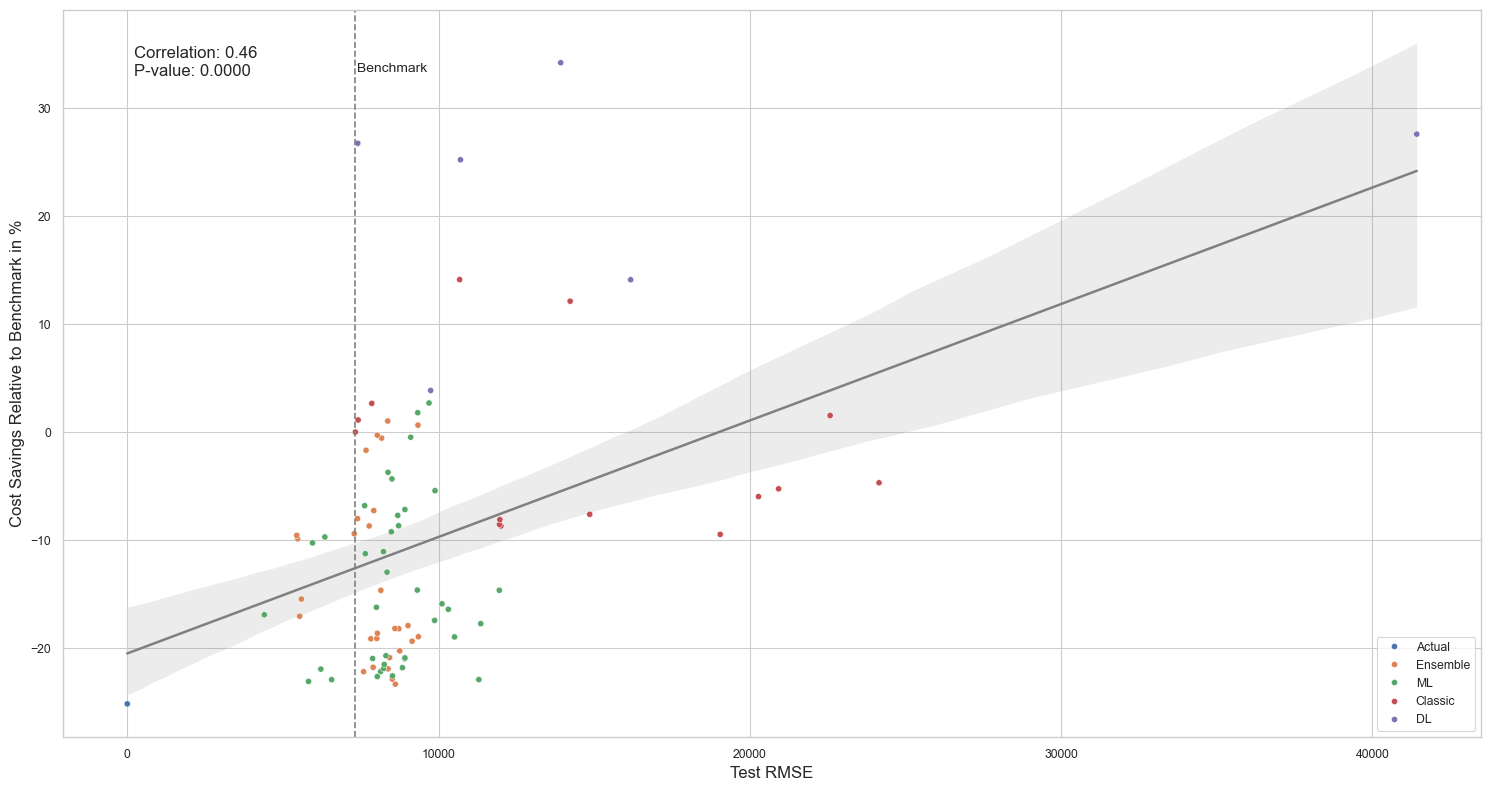

In [14]:
ens_metrics = pd.read_excel("../data/modelling_results/ensemble_metrics_v2.xlsx")

# Merge the two DataFrames based on the model names
merged_df = pd.merge(evaluation_df, ens_metrics, left_on='model', right_on='category')

# Apply the function to the DataFrame
merged_df['model_category'] = merged_df['model'].apply(categorize_model)

# Get the val_rmse score for "L_4_sarimax" model
sarimax_rmse = merged_df.loc[merged_df['model'] == "L_4_sarimax", 'pred_rmse'].values[0]

# Set Seaborn style for an academic format
sns.set(style="whitegrid")
sns.set_context("paper")

# Create the figure
plt.figure(figsize=(15, 8))

# Plot the regression line using sns.regplot
sns.regplot(x='pred_rmse', y='rel_mean_cost_total_bench', data=merged_df, scatter=False, line_kws={'color':'grey'})

# Plot the points using sns.scatterplot
sns.scatterplot(x='pred_rmse', y='rel_mean_cost_total_bench', data=merged_df, hue="model_category", s=20)

# Draw a vertical line for the "L_4_sarimax" model's val_rmse score
plt.axvline(sarimax_rmse, color='grey', linestyle='--')
plt.annotate('Benchmark', xy=(sarimax_rmse, merged_df['rel_mean_cost_total_bench'].max()), 
             xytext=(sarimax_rmse+50, merged_df['rel_mean_cost_total_bench'].max()), 
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='left', verticalalignment='top', fontsize=10)

# Calculate the correlation coefficient and p-value
corr_coeff, p_value = pearsonr(merged_df['pred_rmse'], merged_df['rel_mean_cost_total_bench'])

# Annotate the plot with the correlation coefficient and p-value
plt.annotate(f'Correlation: {corr_coeff:.2f}\nP-value: {p_value:.4f}', 
             xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, verticalalignment='top')

# Set labels and title for the plot
plt.xlabel('Test RMSE', fontsize=12)
plt.ylabel('Cost Savings Relative to Benchmark in %', fontsize=12)

# Move the legend to the bottom right corner
plt.legend(loc='lower right')

# Display the plot
plt.tight_layout()
#plt.savefig('../data/figures/scatter_rmse_cost.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
penalty

27.5

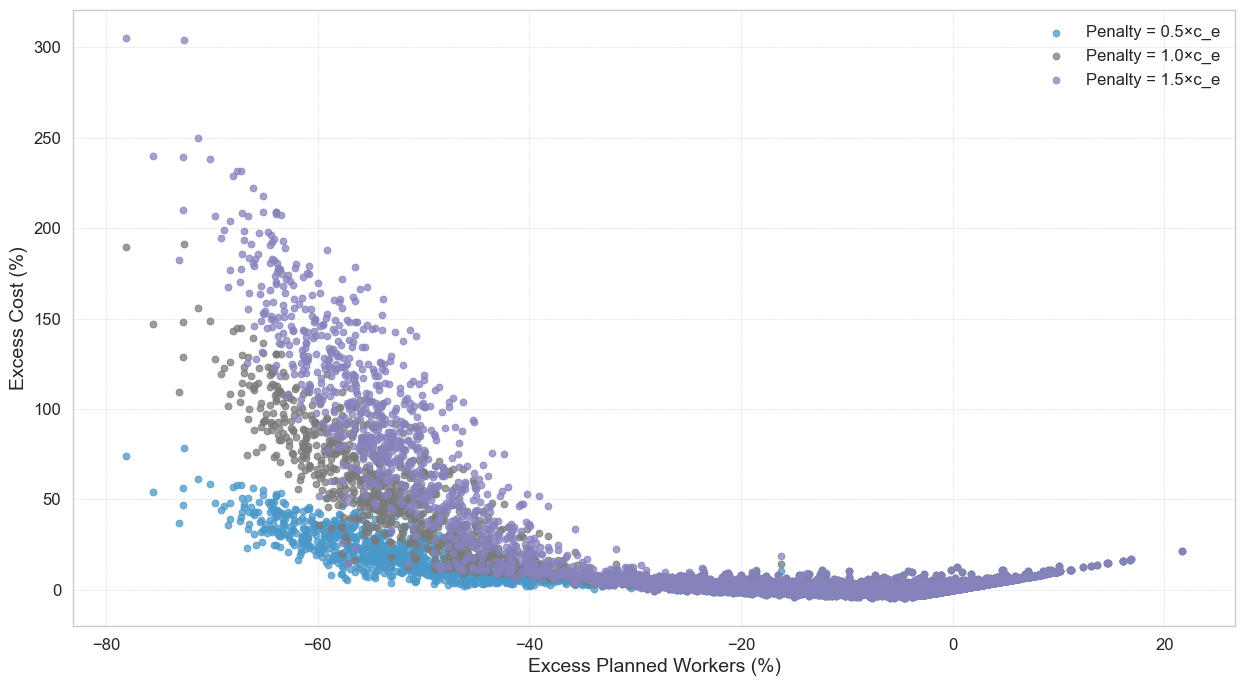

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define excess function
def excess_function(model, bench):
    excess = np.round(((model - bench) / bench) * 100, 4)
    return excess

# Data (please keep this format)
scenario = 1
model = 'L_4_Time_Momentum_Lag_lgbm'
benchmark_model = "actual"

# Assume these parameters are defined as in your evaluation:
p_s = 90       # productivity conversion factor for slack
c_e = 22       # extra worker cost per shift

# Define penalty multipliers to test: 0.5, 1, and 1.5 times c_e
penalty_multipliers = [0.5, 1.0, 1.5]

# Compute excess planned workers once (this does not depend on penalty)
wp_excess = excess_function(
    np.sum(c_robust_dict[scenario][model]["w_p"][:, :, :], axis=1).flatten(), 
    np.sum(c_robust_dict[scenario][benchmark_model]["w_p"][:, :, :], axis=1).flatten()
)

# Define academic-friendly colors (subdued)
academic_colors = [plt.cm.Blues(0.6), plt.cm.Greys(0.6), plt.cm.Purples(0.6)]

plt.figure(figsize=(15, 8))

for i, multiplier in enumerate(penalty_multipliers):
    current_penalty = multiplier * c_e  # penalty = multiplier * extra worker cost
    
    # Compute model cost including slack penalty for the current multiplier
    model_cost_total = np.sum(c_robust_dict[scenario][model]["cost"][:, :, :], axis=1).flatten() + \
                       (np.sum(c_robust_dict[scenario][model]["s"][:, :, :], axis=1).flatten() / p_s) * current_penalty
    bench_cost_total = np.sum(c_robust_dict[scenario][benchmark_model]["cost"][:, :, :], axis=1).flatten() + \
                       (np.sum(c_robust_dict[scenario][benchmark_model]["s"][:, :, :], axis=1).flatten() / p_s) * current_penalty

    # Compute excess cost (%) versus benchmark for the current penalty multiplier
    cost_excess = excess_function(model_cost_total, bench_cost_total)

    # Scatter plot for the current multiplier with muted colors
    plt.scatter(wp_excess, cost_excess, color=academic_colors[i], alpha=0.75, label=f'Penalty = {multiplier}×c_e')

# Improve styling
plt.xlabel('Excess Planned Workers (%)', fontsize=14)
plt.ylabel('Excess Cost (%)', fontsize=14)
plt.legend(fontsize=12, frameon=False)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('../data/figures/penalty_costs_scatter_lgbm.png', dpi=300, bbox_inches='tight')
plt.show()


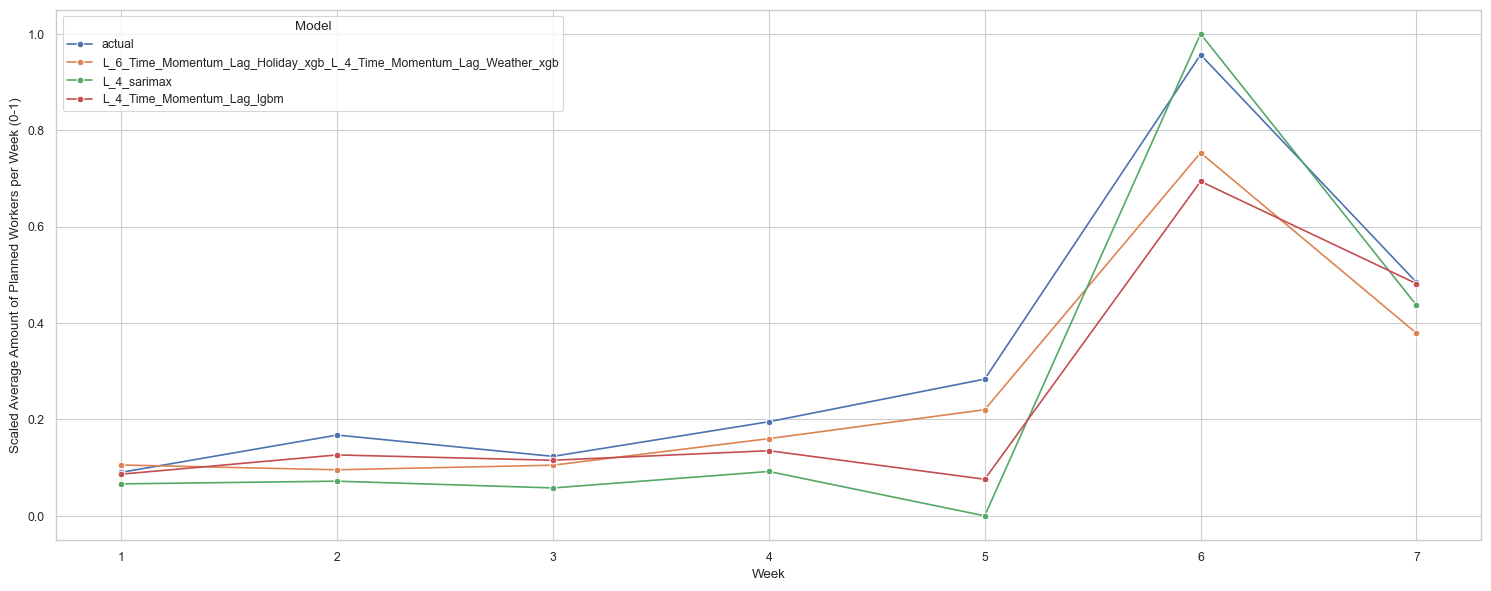

In [17]:
# Initialize an empty list to store the data
data_list = []

# Select data
for model in c_robust_dict[0].keys():
    for week in range(7):
        amount_planned_workers = np.mean(np.sum(c_robust_dict[1][model]["w_p"][week, :, :], axis=0).flatten())
        
        # Add week number, model name, and number of planned workers to list
        data_list.append([week+1, model, amount_planned_workers])

# Create a DataFrame from the list
planned_workers_df = pd.DataFrame(data_list, columns=['week', 'model', 'amount_planned_workers'])

# Plot
filtered_df = planned_workers_df.copy()

# Scale the 'amount_planned_workers' column between 0 and 1
scaler = MinMaxScaler()
filtered_df['scaled_planned_workers'] = scaler.fit_transform(filtered_df[['amount_planned_workers']])

# Set Seaborn style for an academic format
sns.set(style="whitegrid")
sns.set_context("paper")

# Plotting
plt.figure(figsize=(15, 6))
sns.lineplot(data=filtered_df, x='week', y='scaled_planned_workers', hue='model', marker='o')

# Setting title and labels
plt.xlabel('Week')
plt.ylabel('Scaled Average Amount of Planned Workers per Week (0-1)')
plt.legend(title='Model')

# Display the plot
plt.tight_layout()
plt.savefig('../data/figures/planned_workers_week_lgbm.png', dpi=300, bbox_inches='tight')
plt.show()


## Boxplot Analysis

In [26]:
f_model

'L_4_Time_Momentum_Lag_lgbm'

In [ ]:
"L_6_Time_Momentum_Lag_Holiday_xgb_L_4_Time_Momentum_Lag_Weather_xgb"

In [29]:
model_keys=["actual", "L_6_Time_Momentum_Lag_Holiday_xgb_L_4_Time_Momentum_Lag_Weather_xgb", 
              "L_4_sarimax"]

### Planned workers

actual
L_6_Time_Momentum_Lag_Holiday_xgb_L_4_Time_Momentum_Lag_Weather_xgb
L_4_sarimax


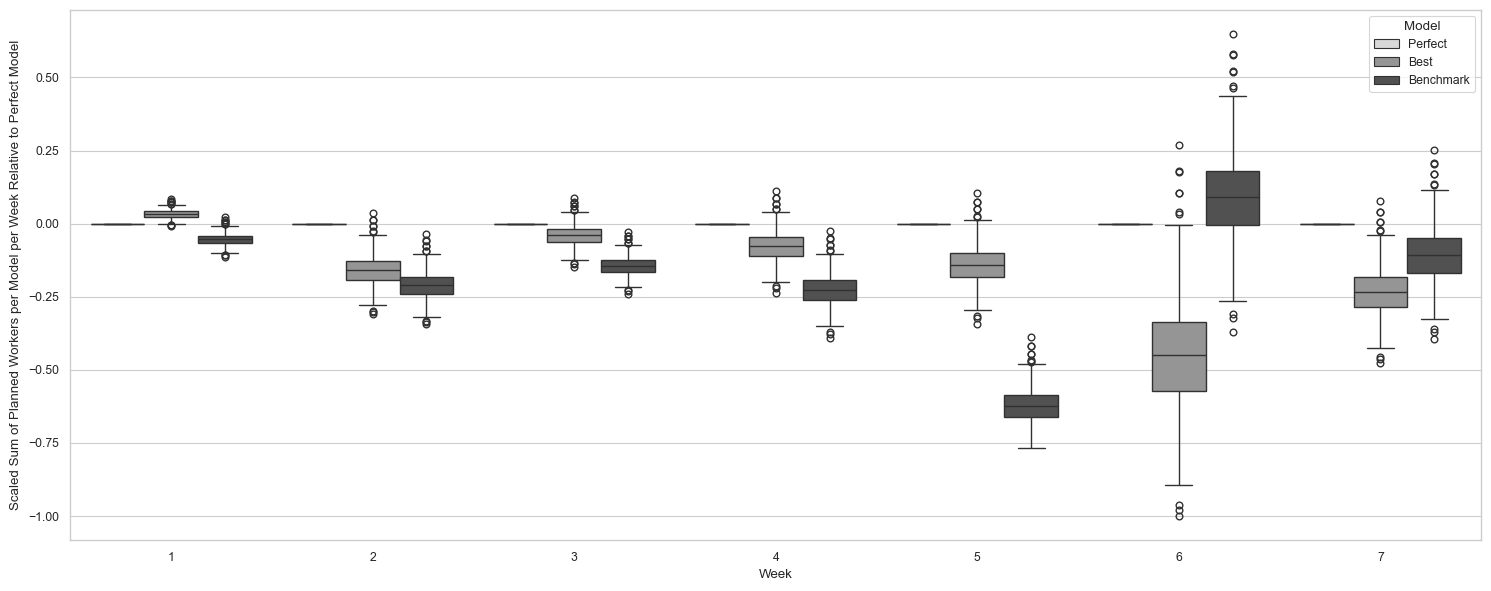

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize an empty list to store the data
data_list = []

# Initialize variables to keep track of the overall min and max values of w_p
overall_min = np.inf
overall_max = -np.inf

# Loop through each model and week to collect data
for model in model_keys:
    print(model)
    for week in range(7):
        
        amount_planned_workers = np.sum(c_robust_dict[0][model]["w_p"][week, :, :], axis=0).flatten() - np.sum(c_robust_dict[0]["actual"]["w_p"][week, :, :], axis=0).flatten()
        
        # Update overall min and max
        overall_min = min(overall_min, np.min(amount_planned_workers))
        overall_max = max(overall_max, np.max(amount_planned_workers))
        
        # Add week number, model name, and amount of planned workers to list
        for val in amount_planned_workers:
            data_list.append([week+1, model, val])

# Create a DataFrame from the list
planned_workers_df = pd.DataFrame(data_list, columns=['week', 'model', 'amount_planned_workers'])

# Scale the 'amount_planned_workers' column between overall_min and overall_max
# Find the absolute maximum value among the overall minimum and maximum values
abs_max = max(abs(overall_min), abs(overall_max))

# Conditionally scale the 'amount_planned_workers' column between -1 and 1
planned_workers_df['scaled_planned_workers'] = planned_workers_df['amount_planned_workers'].apply(lambda x: x / abs_max if abs_max != 0 else 0)



# Set Seaborn style for an academic format
sns.set(style="whitegrid")
sns.set_context("paper")

# Plotting
plt.figure(figsize=(15, 6))

# Create boxplots
ax = sns.boxplot(data=planned_workers_df, x='week', y='scaled_planned_workers', hue='model', palette="Greys")

# Setting title and labels
plt.xlabel('Week')
plt.ylabel('Scaled Sum of Planned Workers per Model per Week Relative to Perfect Model')

# Get the handles and labels from Seaborn's boxplot
handles, labels = ax.get_legend_handles_labels()

# Define your custom labels
custom_labels = ['Perfect', 'Best', 'Benchmark']

# Set the custom legend
plt.legend(handles, custom_labels, title='Model')

# Display the plot
plt.tight_layout()
plt.savefig('../data/figures/box_planned_workers_week_lgbm.png', dpi=300, bbox_inches='tight')
plt.show()


## Slack

actual
L_6_Time_Momentum_Lag_Holiday_xgb_L_4_Time_Momentum_Lag_Weather_xgb
L_4_sarimax


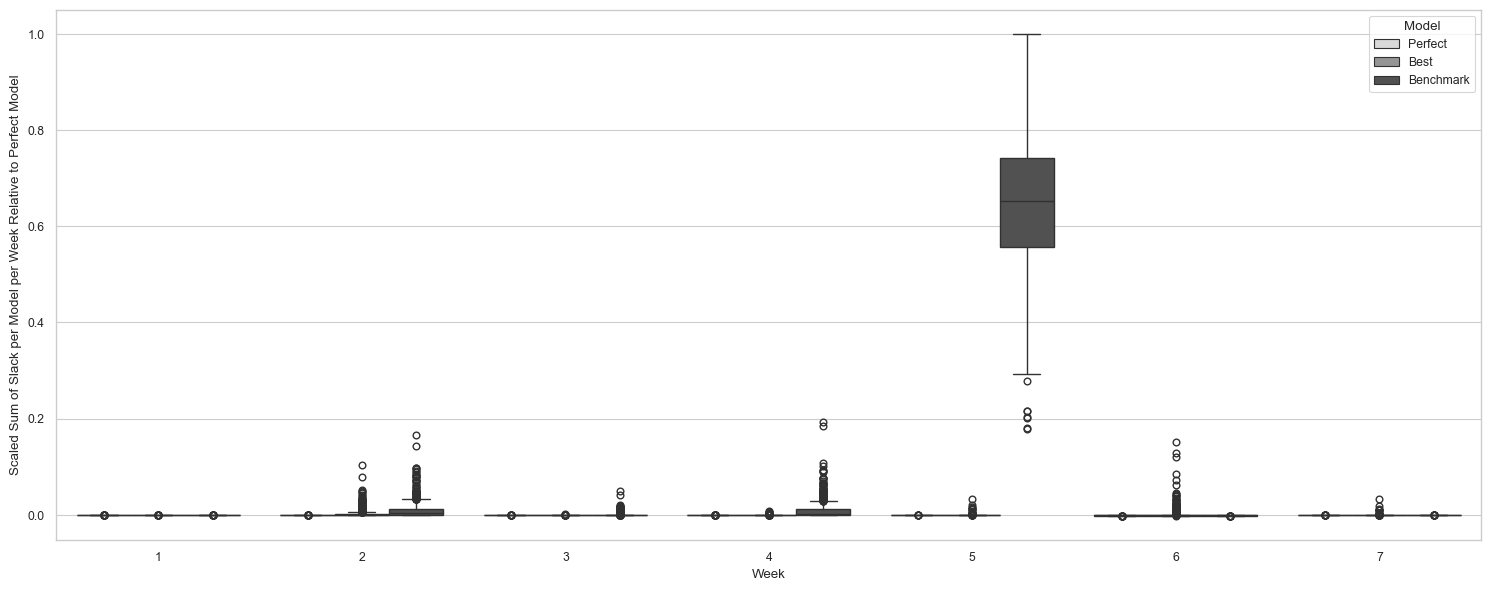

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize an empty list to store the data
data_list = []

# Initialize variables to keep track of the overall min and max values of w_p
overall_min = np.inf
overall_max = -np.inf

# Loop through each model and week to collect data
for model in model_keys:
    print(model)
    for week in range(7):
        
        amount_planned_workers = np.sum(c_robust_dict[0][model]["s"][week, :, :], axis=0).flatten() - np.sum(c_robust_dict[0]["actual"]["w_p"][week, :, :], axis=0).flatten()
        
        # Update overall min and max
        overall_min = min(overall_min, np.min(amount_planned_workers))
        overall_max = max(overall_max, np.max(amount_planned_workers))
        
        # Add week number, model name, and amount of planned workers to list
        for val in amount_planned_workers:
            data_list.append([week+1, model, val])

# Create a DataFrame from the list
planned_workers_df = pd.DataFrame(data_list, columns=['week', 'model', 'amount_planned_workers'])

# Scale the 'amount_planned_workers' column between overall_min and overall_max
# Find the absolute maximum value among the overall minimum and maximum values
abs_max = max(abs(overall_min), abs(overall_max))

# Conditionally scale the 'amount_planned_workers' column between -1 and 1
planned_workers_df['scaled_planned_workers'] = planned_workers_df['amount_planned_workers'].apply(lambda x: x / abs_max if abs_max != 0 else 0)



# Set Seaborn style for an academic format
sns.set(style="whitegrid")
sns.set_context("paper")

# Plotting
plt.figure(figsize=(15, 6))

# Create boxplots
ax = sns.boxplot(data=planned_workers_df, x='week', y='scaled_planned_workers', hue='model', palette="Greys")

# Setting title and labels
plt.xlabel('Week')
plt.ylabel('Scaled Sum of Slack per Model per Week Relative to Perfect Model')

# Get the handles and labels from Seaborn's boxplot
handles, labels = ax.get_legend_handles_labels()

# Define your custom labels
custom_labels = ['Perfect', 'Best', 'Benchmark']

# Set the custom legend
plt.legend(handles, custom_labels, title='Model')

# Display the plot
plt.tight_layout()
plt.savefig('../data/figures/box_slack_week_lgbm.png', dpi=300, bbox_inches='tight')
plt.show()


# Old evaluation